<a href="https://colab.research.google.com/github/kakkia/final_project/blob/main/tf_binary_vs_categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# model for transfer learning from keras tutorial 

base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

In [3]:
# set up of mydataset

import pathlib

data = "/content/drive/MyDrive/dataset"
dataset = pathlib.Path(data)
test = "/content/drive/MyDrive/validation"
test_ds = pathlib.Path(test)

In [4]:
image_count = len(list(dataset.glob('*/*.jpg')))
print(image_count)

1007


In [5]:
image_count = len(list(test_ds.glob('*/*.jpg')))
print(image_count)

154


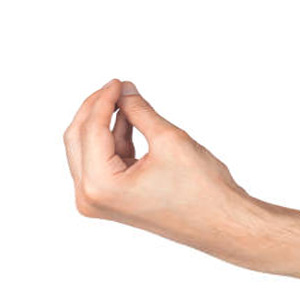

In [6]:
what = list(dataset.glob('what/*'))
PIL.Image.open(str(what[0]))

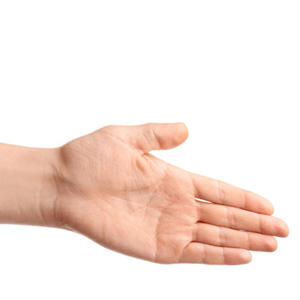

In [7]:
shoo = list(dataset.glob('shoo/*'))
PIL.Image.open(str(shoo[20]))

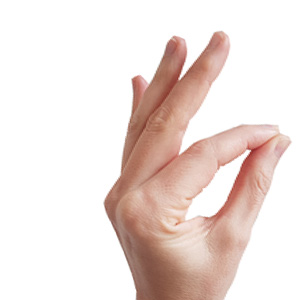

In [8]:
perfect = list(dataset.glob('perfect/*'))
PIL.Image.open(str(perfect[120]))

In [9]:
# parameters for the loader 

batch_size = 32
img_height = 180
img_width = 180

In [10]:
# It's good practice to use a validation split when developing your model. 
# Let's use 80% of the images for training, and 20% for validation.

train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1007 files belonging to 3 classes.
Using 806 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1007 files belonging to 3 classes.
Using 201 files for validation.


In [12]:
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)


['perfect', 'shoo', 'what']


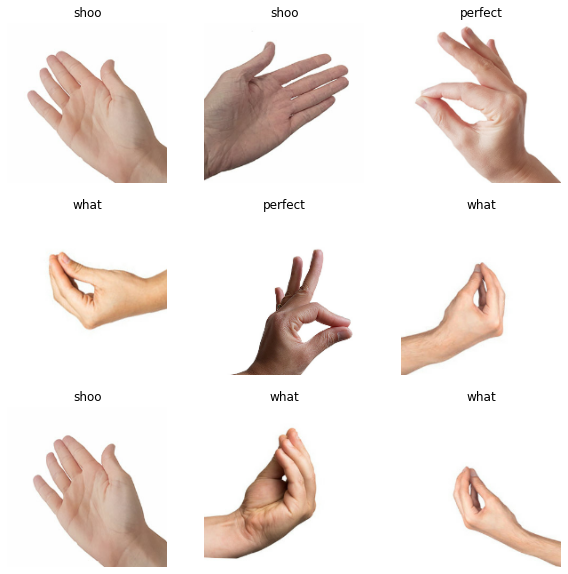

In [13]:
# visualizing the first images from the training dataset 

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
# The image_batch is a tensor of the shape (32, 180, 180, 3). 
# This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). 
# The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
# You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray.

In [15]:
# Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch.
# Dataset.prefetch overlaps data preprocessing and model execution while training

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
# The RGB channel values are in the [0, 255] range.
# This is not ideal for a neural network; in general you should seek to make your input values small.
# Here, you will standardize values to be in the [0, 1] range by using tf.keras.layers.Rescaling in the model 

num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 45, 45, 64)        1

In [19]:
# train the model 

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 200s 2s/step - loss: 1.5258 - accuracy: 0.3759 - val_loss: 1.0603 - val_accuracy: 0.5871
Epoch 2/10
26/26 [==============================] - 1s 47ms/step - loss: 0.9086 - accuracy: 0.5769 - val_loss: 0.9312 - val_accuracy: 0.5423
Epoch 3/10
26/26 [==============================] - 1s 45ms/step - loss: 0.7714 - accuracy: 0.6725 - val_loss: 0.7038 - val_accuracy: 0.6866
Epoch 4/10
26/26 [==============================] - 1s 45ms/step - loss: 0.5322 - accuracy: 0.8027 - val_loss: 0.5709 - val_accuracy: 0.7264
Epoch 5/10
26/26 [==============================] - 1s 45ms/step - loss: 0.3427 - accuracy: 0.8722 - val_loss: 0.5209 - val_accuracy: 0.7463
Epoch 6/10
26/26 [==============================] - 1s 45ms/step - loss: 0.2171 - accuracy: 0.9231 - val_loss: 0.4811 - val_accuracy: 0.8010
Epoch 7/10
26/26 [==============================] - 1s 46ms/step - loss: 0.1520 - accuracy: 0.9553 - val_loss: 0.4889 - val_accuracy: 0.8408
Epoch 8/10
26

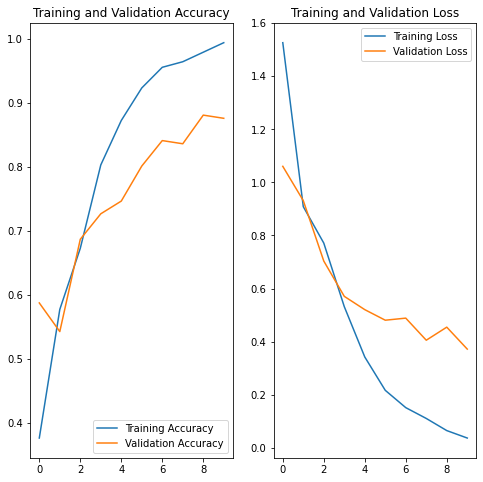

In [20]:
# visualizing training results 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# data augmentation for overfitting

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

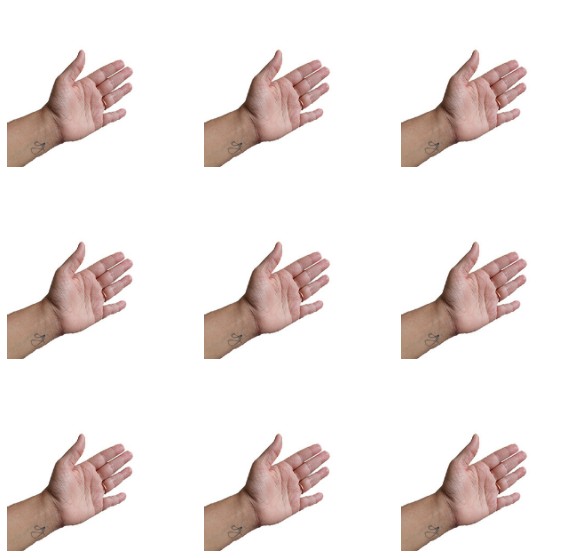

In [22]:
# visualizing augmented examples 

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [23]:
# reducing overfitting with dropout 

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [24]:
# compile and train the model 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [26]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
26/26 [==============================] - 3s 63ms/step - loss: 1.7258 - accuracy: 0.3536 - val_loss: 1.1011 - val_accuracy: 0.3433
Epoch 2/15
26/26 [==============================] - 1s 52ms/step - loss: 1.0895 - accuracy: 0.4293 - val_loss: 1.0757 - val_accuracy: 0.3284
Epoch 3/15
26/26 [==============================] - 1s 52ms/step - loss: 0.9772 - accuracy: 0.5261 - val_loss: 0.8461 - val_accuracy: 0.6368
Epoch 4/15
26/26 [==============================] - 1s 52ms/step - loss: 0.8735 - accuracy: 0.6377 - val_loss: 0.9155 - val_accuracy: 0.6517
Epoch 5/15
26/26 [==============================] - 1s 51ms/step - loss: 0.7369 - accuracy: 0.6762 - val_loss: 0.6738 - val_accuracy: 0.7463
Epoch 6/15
26/26 [==============================] - 1s 52ms/step - loss: 0.6004 - accuracy: 0.7481 - val_loss: 0.5605 - val_accuracy: 0.7562
Epoch 7/15
26/26 [==============================] - 1s 52ms/step - loss: 0.5360 - accuracy: 0.7692 - val_loss: 0.4792 - val_accuracy: 0.7910
Epoch 8/15
26

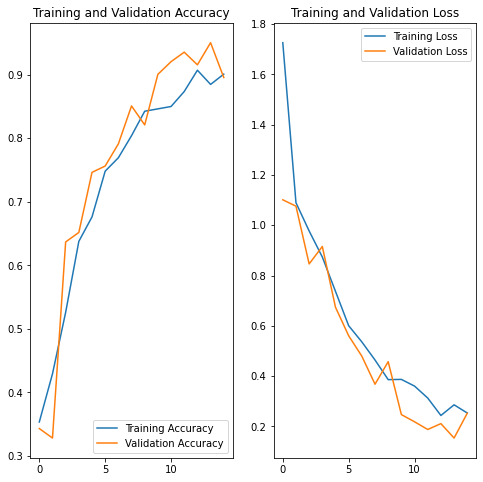

In [27]:
# visualizing the results 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [28]:
# predicting new data not included in the training or validation sets

prediction = "/content/drive/MyDrive/validation/perfect/perfect1.jpg"

img = tf.keras.utils.load_img(
    prediction, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to perfect with a 89.89 percent confidence.


In [29]:
# predicting new data not included in the training or validation sets

prediction = "/content/drive/MyDrive/validation/what/24what.jpg"

img = tf.keras.utils.load_img(
    prediction, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to what with a 89.25 percent confidence.


In [36]:
# predicting new data not included in the training or validation sets

prediction = "/content/drive/MyDrive/validation/shoo/shoo2.jpg"

img = tf.keras.utils.load_img(
    prediction, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to perfect with a 100.00 percent confidence.


In [ ]:
# seems like my model is confusing shoo with perfect 

# Transfer learning and fin-tuning

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [38]:
train_dir = "/content/drive/MyDrive/dataset"
validation_dir = "/content/drive/MyDrive/validation"

In [42]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1007 files belonging to 3 classes.


In [43]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 154 files belonging to 3 classes.


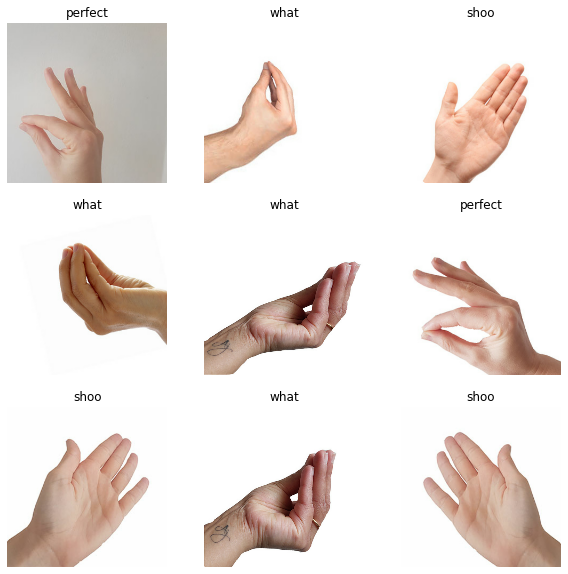

In [44]:
# first images from the training set 

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contain a test set, you will create one. To do so, determine how many batches of data are available in the validation set using tf.data.experimental.cardinality, then move 20% of them to a test set.

In [45]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [46]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 1


In [47]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [48]:
# random data augmentation 

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

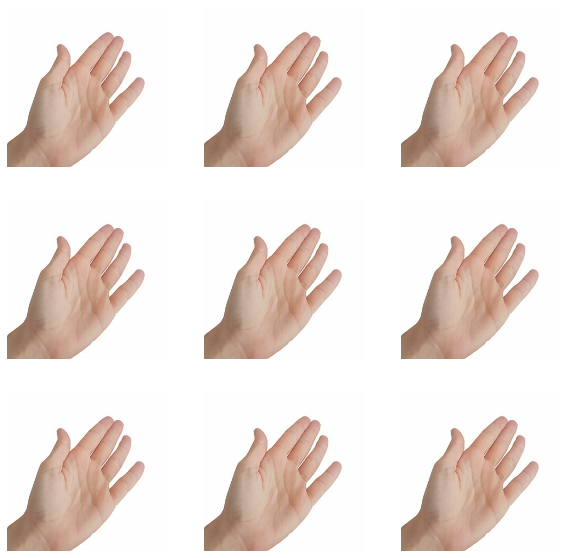

In [49]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel values in [-1, 1], but at this point, the pixel values in your images are in [0, 255]. To rescale them, use the preprocessing method included with the model.

In [50]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# or rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. This base of knowledge will help us classify our specific dataset.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [51]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [52]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

In [53]:
base_model.trainable = False

In [54]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [55]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


# when i change dense layer and binary entropy the model is highly inaccurate and predictions fail

Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. Positive numbers predict class 1, negative numbers predict class 0.

In [56]:
# I have more than two classes so i am replacing 1 with standard (32, activation='relu')

prediction_layer = tf.keras.layers.Dense(32, activation='relu')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 32)


In [57]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [58]:
# compile the model with binary crossentropy that is no good to me so i am replacing BinaryCrossentropy with SparseCategoricalCrossentropy

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [59]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases

In [60]:
len(model.trainable_variables)

2

In [61]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 58s 184ms/step - loss: 3.7619 - accuracy: 0.0082


In [62]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.76
initial accuracy: 0.01


In [63]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
32/32 [==============================] - 8s 115ms/step - loss: 3.3380 - accuracy: 0.0963 - val_loss: 2.5784 - val_accuracy: 0.3115
Epoch 2/10
32/32 [==============================] - 4s 100ms/step - loss: 2.3769 - accuracy: 0.3366 - val_loss: 1.7444 - val_accuracy: 0.3934
Epoch 3/10
32/32 [==============================] - 4s 100ms/step - loss: 1.6400 - accuracy: 0.4459 - val_loss: 1.0417 - val_accuracy: 0.6885
Epoch 4/10
32/32 [==============================] - 4s 100ms/step - loss: 1.2008 - accuracy: 0.5780 - val_loss: 0.8130 - val_accuracy: 0.7459
Epoch 5/10
32/32 [==============================] - 4s 102ms/step - loss: 1.0184 - accuracy: 0.6425 - val_loss: 0.6675 - val_accuracy: 0.7869
Epoch 6/10
32/32 [==============================] - 4s 102ms/step - loss: 0.8751 - accuracy: 0.6981 - val_loss: 0.6017 - val_accuracy: 0.8443
Epoch 7/10
32/32 [==============================] - 4s 100ms/step - loss: 0.7557 - accuracy: 0.7617 - val_loss: 0.5082 - val_accuracy: 0.8607
Epoch 

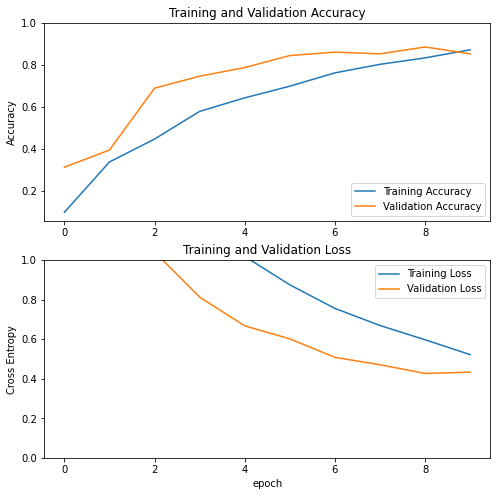

In [64]:
# learning curve 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [65]:
# unfreeze the top layers 

base_model.trainable = True

In [66]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [69]:
len(model.trainable_variables)

56

In [70]:
# improving accuracy 

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
32/32 [==============================] - 10s 148ms/step - loss: 3.1493 - accuracy: 0.2870 - val_loss: 2.4791 - val_accuracy: 0.2787
Epoch 11/20
32/32 [==============================] - 4s 112ms/step - loss: 2.3340 - accuracy: 0.3635 - val_loss: 2.2695 - val_accuracy: 0.2623
Epoch 12/20
32/32 [==============================] - 4s 115ms/step - loss: 2.3687 - accuracy: 0.3128 - val_loss: 2.1848 - val_accuracy: 0.4590
Epoch 13/20
32/32 [==============================] - 4s 116ms/step - loss: 2.3088 - accuracy: 0.3585 - val_loss: 2.2437 - val_accuracy: 0.2541
Epoch 14/20
32/32 [==============================] - 4s 114ms/step - loss: 2.2929 - accuracy: 0.3158 - val_loss: 2.2532 - val_accuracy: 0.4098
Epoch 15/20
32/32 [==============================] - 4s 114ms/step - loss: 2.3084 - accuracy: 0.3178 - val_loss: 2.2863 - val_accuracy: 0.2623
Epoch 16/20
32/32 [==============================] - 4s 112ms/step - loss: 2.2968 - accuracy: 0.3198 - val_loss: 2.4163 - val_accuracy: 0.237

In [71]:
# learning curves when fine-tuning the last few layers of the MobileNetV2 base model and training the classifier on top of it.

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

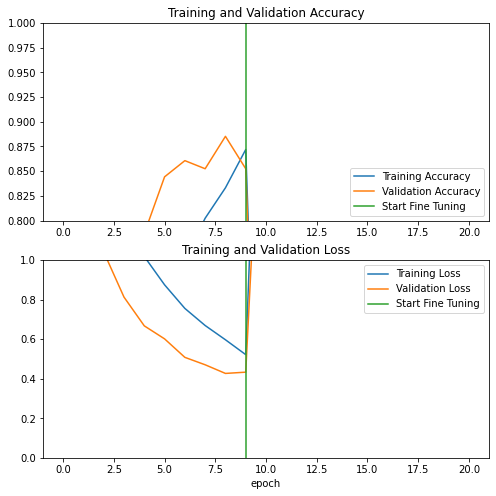

In [72]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [73]:
# evaluation and predictions 

loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 485ms/step - loss: 2.3955 - accuracy: 0.3125
Test accuracy : 0.3125


Predictions:
 [1 1 1 ... 1 1 1]
Labels:
 [2 2 1 1 2 2 1 1 2 0 0 1 0 1 2 2 0 1 0 2 1 1 1 2 2 0 1 1 2 0 1 0]


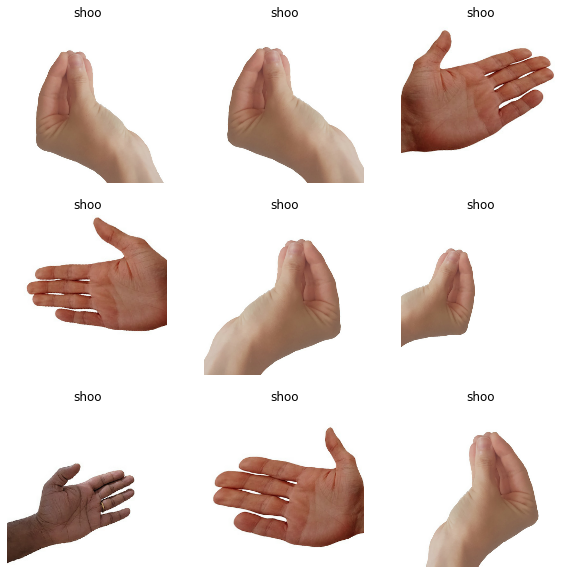

In [74]:
# predict a new image 

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

# Using a pre-trained model for feature extraction

When working with a small dataset, it is a common practice to take advantage of features learned by a model trained on a larger dataset in the same domain. This is done by instantiating the pre-trained model and adding a fully-connected classifier on top. The pre-trained model is "frozen" and only the weights of the classifier get updated during training. In this case, the convolutional base extracted all the features associated with each image and you just trained a classifier that determines the image class given that set of extracted features.

# Fine-tuning a pre-trained model

To further improve performance, one might want to repurpose the top-level layers of the pre-trained models to the new dataset via fine-tuning. In this case, you tuned your weights such that your model learned high-level features specific to the dataset. This technique is usually recommended when the training dataset is large and very similar to the original dataset that the pre-trained model was trained on.